In [601]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import operator

from scipy.optimize import curve_fit
import matplotlib.colors as mcolors


from tqdm.notebook import tqdm

np.random.seed(0)

In [594]:
#for i in range(1,6):
#    fst_params = [i, [], np.log(i), np.random.rand()*360]
#    nodes_df = nodes_df.append({k:v for k, v in zip(nodes_df.columns, fst_params)}, ignore_index=True)

In [595]:
def add_node(nodes_df: pd.DataFrame,m: int, T: int, beta: float = 0) -> pd.DataFrame:
    
    def create_connection(id1, id2):
        node = nodes_df[nodes_df.id == id1]
        elist = node.edges.values[0]
        idx = node.index.values[0]
        elist.append(id2)
        nodes_df.at[idx, "edges"] = elist

        node = nodes_df[nodes_df.id == id2]
        elist = node.edges.values[0]
        idx = node.index.values[0]
        elist.append(id1)
        nodes_df.at[idx, "edges"] = elist

    new_id = len(nodes_df) + 1
    fst_params = [new_id, [], np.log(new_id), np.random.rand()*360]
    nodes_df = nodes_df.append({k:v for k, v in zip(nodes_df.columns, fst_params)}, ignore_index=True)
    
    if len(nodes_df)-1 <= m:
        for id_ in nodes_df.id[:-1]:
            create_connection(id_, new_id)
        return nodes_df

    dists = {}
    
    newnode = nodes_df.loc[nodes_df.id == new_id]
    
    for index, node in nodes_df.iterrows():
        if node['id'] != new_id:
            dist = calculate_dist(nodes_df, node["id"], new_id, beta = beta)
            dists[node["id"]] = dist
    sorted_dists = sorted(dists.items(), key=operator.itemgetter(1))
    
    m_put = 0
    put = []
    while m_put < m:
        for nodeid, dist in sorted_dists:
            r = np.random.rand()
            prob = 1/(1 + np.exp((dist-np.log(new_id))/T ))
            if r<= prob and nodeid not in put:
                create_connection(nodeid, new_id)
                m_put += 1
                put.append(nodeid)
            else:
                continue
            if m_put>=m:
                break
    return nodes_df
    

In [596]:
def current_radius(nodeid, t, beta):
    return beta*np.log(nodeid) + (1-beta)*np.log(t)

In [597]:
def calculate_dist(nodes_df: pd.DataFrame, nodeid: int, newNodeid: int, beta: float = 0):
    node1, node2 = nodes_df.loc[nodes_df.id == nodeid], nodes_df.loc[nodes_df.id == newNodeid]
    rad1, rad2 = current_radius(nodeid, newNodeid, beta = beta), np.log(newNodeid)
    return rad1 + rad2 + np.log(abs(float(node1.theta)-float(node2.theta))/2)

In [598]:
def create_dataframe(n: int = 50, m: int = 3, T: float = 1., beta: float = 1.):
    nodes_df = pd.DataFrame(columns = ['id', 'edges', 'r', 'theta'])
    for _ in tqdm(range(n)):
        nodes_df = add_node(nodes_df,m = m, T = T, beta = beta)
    
    return nodes_df

In [599]:
def update_df(nodes_df: pd.DataFrame, beta: float = 0) -> pd.DataFrame:
    t = len(nodes_df)
    current_rad = [ current_radius(nodeid_, t, beta = beta) for nodeid_ in nodes_df.id]
    num_of_edges = [len(elist) for elist in nodes_df.edges]
    nodes_df["current_rad"] = current_rad
    nodes_df["num_of_edges"] = num_of_edges
    return nodes_df

In [600]:
all_betas = {beta: update_df(create_dataframe(n = 400, m = 5, T = 2, beta = beta),\
                       beta = beta) for beta in np.linspace(0, 1, 10)}

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [613]:
all_temps = {temp: update_df(create_dataframe(n = 400, m = 5, T = temp, beta = .67),\
                       beta = .67) for temp in np.logspace(0, 3, 10)}

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [587]:
def hist(nodes_df: pd.DataFrame, bins = 200):
    hist, bin_edges = np.histogram(nodes_df.num_of_edges, bins = 200)
    be = [ (i + j)/2 for i,j in zip(bin_edges[:-1],bin_edges[1:] )]
    nonzero = {h:b for h, b in zip(hist, be) if h !=0 }
    nonzero_ = dict( sorted(nonzero.items(), key=operator.itemgetter(0)))
    return list(nonzero_.values()), list(nonzero_.keys())


In [588]:
def power_law(k, c, gamma):
    return c*k**(-gamma)

(None, <matplotlib.legend.Legend at 0x7fdd45bba7c0>)

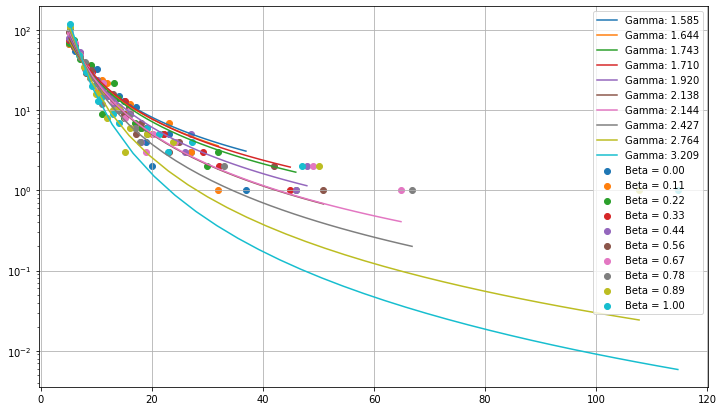

In [607]:
fig, ax = plt.subplots(1,1, figsize=(12, 7), facecolor = 'white')

colors = mcolors.TABLEAU_COLORS.keys()

for (beta, nodes), color in zip(all_betas.items(), colors):
    h, b = hist(nodes)
    popt, pcov = curve_fit(power_law, h, b)
    ax.scatter(h, b, label = f'Beta = {beta:.2f}', color = color)
    h_ = np.linspace(min(h), max(h), 30)
    ax.plot(h_, [power_law(i, *popt)for i in h_], label=f"Gamma: {popt[1]:.3f}", color = color)

    
ax.set_yscale("log")
ax.grid(), ax.legend()

(None, <matplotlib.legend.Legend at 0x7fdd0aefa130>)

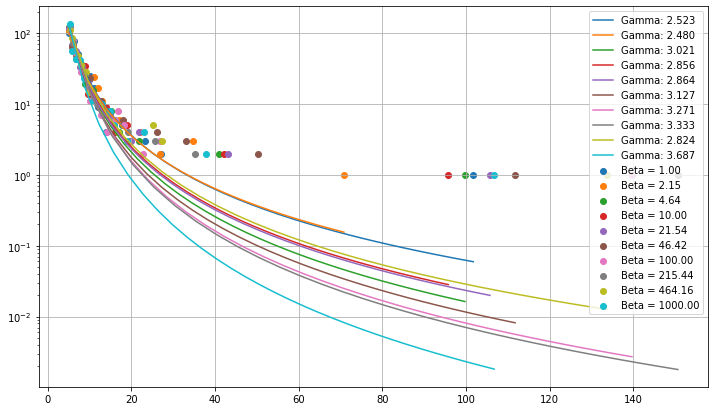

In [615]:
fig, ax = plt.subplots(1,1, figsize=(12, 7), facecolor = 'white')

colors = mcolors.TABLEAU_COLORS.keys()

for (temp, nodes), color in zip(all_temps.items(), colors):
    h, b = hist(nodes)
    popt, pcov = curve_fit(power_law, h, b)
    ax.scatter(h, b, label = f'Beta = {temp:.2f}', color = color)
    h_ = np.linspace(min(h), max(h), 30)
    ax.plot(h_, [power_law(i, *popt)for i in h_], label=f"Gamma: {popt[1]:.3f}", color = color)

    
ax.set_yscale("log")
ax.grid(), ax.legend()

In [461]:
node = nodes_df.loc[nodes_df.id == 2]


In [182]:
elist = nodes_df[nodes_df.id == 3].edges.values[0]


In [183]:
elist

[]

In [290]:
nodes_df.head()


,id,edges,r,theta
0,1,[],0.000000,111.808780
1,2,[],0.693147,273.780787
2,3,[],1.098612,17.476965
3,4,[],1.386294,253.974674
4,5,[],1.609438,164.630717


odict_keys(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])